# Experiments on Tosato's Benchmark Datasets

**Important Note:** These are not *the* experiments from the paper, but me re-implementing the same experiments after the fact in order to clean up the code and use the [DeepFried2](https://github.com/lucasb-eyer/DeepFried2) library. This means numbers may be ever so slightly different.

In [50]:
import numpy as np
import pickle, gzip
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
%matplotlib inline

# Font which got unicode math stuff.
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Much more readable plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
import DeepFried2 as df

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled)


In [246]:
from lbtoolbox.augmentation import AugmentationPipeline, Cropper
from lbtoolbox.thutil import count_params
from lbtoolbox.util import batched

from lbtoolbox.plotting import liveplot, annotline
from lbtoolbox.plotting_sklearn import confuse as confusion

# Utilities

In [63]:
class Flatten(df.Module):
    def symb_forward(self, symb_in):
        return symb_in.flatten(2)

In [258]:
def mknet(*head, midshape=(5,5), extra=df.Identity()):
    return df.Sequential(                          #     3@46
        df.SpatialConvolutionCUDNN( 3, 24, 3, 3),  # -> 24@44
        df.BatchNormalization(24),
        df.ReLU(),
        df.SpatialConvolutionCUDNN(24, 24, 3, 3),  # -> 24@42
        df.BatchNormalization(24),
        df.SpatialMaxPoolingCUDNN(2, 2),           # -> 24@21
        df.ReLU(),
        df.SpatialConvolutionCUDNN(24, 48, 3, 3),  # -> 48@19
        df.BatchNormalization(48),
        df.ReLU(),
        df.SpatialConvolutionCUDNN(48, 48, 3, 3),  # -> 48@17
        df.BatchNormalization(48),
        df.SpatialMaxPooling(2, 2),                # -> 48@9
        df.ReLU(),
        df.SpatialConvolutionCUDNN(48, 64, 3, 3),  # -> 64@7
        df.BatchNormalization(64),
        df.ReLU(),
        df.SpatialConvolutionCUDNN(64, 64, 3, 3),  # -> 64@5
        df.BatchNormalization(64),
        df.ReLU(),
        extra,
        df.Dropout(0.2),
        Flatten(),
        df.Linear(64*np.prod(midshape), 512),
        df.ReLU(),
        df.Dropout(0.5),
        *head
    )

In [154]:
def mknet_classification(nclass):
    return mknet(
        df.Linear(512, nclass, initW=df.init.const(0)),
        df.SoftMax()
    )

In [249]:
def plotcost(costs):
    fig, ax = plt.subplots()
    line, = ax.plot(1+np.arange(len(costs)), costs, label='Training cost')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Cost')
    annotline(ax, line, np.min)
    return fig

In [73]:
def dotrain(model, crit, aug, Xtr, ytr, nepochs=50, batchsize=100):
    opt = df.AdaDelta(rho=.95, eps=1e-7, lr=1)

    progress = IntProgress(value=0, min=0, max=nepochs, description='Training:')
    display(progress)

    model.training()

    costs = []
    for e in range(nepochs):
        batchcosts = []
        for Xb, yb in batched(batchsize, Xtr, ytr, shuf=True):
            if aug is not None:
                Xb, yb = aug.augbatch_train(Xb, yb)
            model.zero_grad_parameters()
            cost = model.accumulate_gradients(Xb, yb, crit)
            opt.update_parameters(model)
            batchcosts.append(cost)
        costs.append(np.mean(batchcosts))
        progress.value = e+1

        liveplot(plotcost, costs)
    return costs

In [136]:
def dostats(model, aug, Xtr, batchsize=100):
    model.training()

    for Xb in batched(batchsize, Xtr):
        if aug is None:
            model.accumulate_statistics(Xb)
        else:
            for Xb_aug in aug.augbatch_pred(Xb):
                model.accumulate_statistics(Xb_aug)

In [151]:
def dopred(model, aug, X, batchsize=100):
    model.evaluate()
    y_preds = []
    for Xb in batched(batchsize, X):
        if aug is None:
            p_y = model.forward(X)
        else:
            p_y = np.mean([model.forward(X) for X in aug.augbatch_pred(Xb)], axis=0)
        y_preds += list(np.argmax(p_y, axis=1))
    return np.array(y_preds)

In [429]:
def dopred(model, aug, X, ensembling, output2preds, batchsize=100):
    model.evaluate()
    y_preds = []
    for Xb in batched(batchsize, X):
        if aug is None:
            p_y = model.forward(X)
        else:
            p_y = ensembling([model.forward(X) for X in aug.augbatch_pred(Xb)])
        y_preds += list(output2preds(p_y))
    return np.array(y_preds)

In [432]:
def dopred_clf(model, aug, X, batchsize=100):
    return dopred(model, aug, X,
        ensembling=lambda p_y: np.mean(p_y, axis=0),
        output2preds=lambda p_y: np.argmax(p_y, axis=1),
        batchsize=batchsize
    )

---

# HIIT

In [13]:
Xtr, Xte, ytr, yte, ntr, nte, le = pickle.load(gzip.open('data/HIIT-wflip.pkl.gz', 'rb'))

In [16]:
aug = AugmentationPipeline(Xtr, ytr, Cropper((46,46)))

In [89]:
nets_hiit = [mknet_classification(len(le.classes_)) for _ in  range(5)]
print('{:.3f}M params'.format(count_params(nets_hiit[0])/1000000))

0.925M params


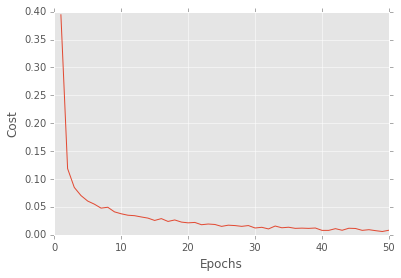

In [95]:
trains_hiit = [dotrain(net, df.ClassNLLCriterion(), aug, Xtr, ytr.astype(df.floatX)) for net in nets_hiit]

The statistics collection pass needs to be done at the end of the training for the batch-normalization to collect its stats.

In [137]:
for model in nets_hiit:
    dostats(model, aug, Xtr, batchsize=1000)

In [140]:
y_preds_hiit = [dopred_clf(net, aug, Xte) for net in nets_hiit]

In [152]:
print("Average accuracy: {:.2%}".format(np.mean([np.mean(y_p == yte) for y_p in y_preds_hiit])))

Average accuracy: 98.83%


Combined confusion matrix of all the networks. This is not what's shown in the paper's appendix.

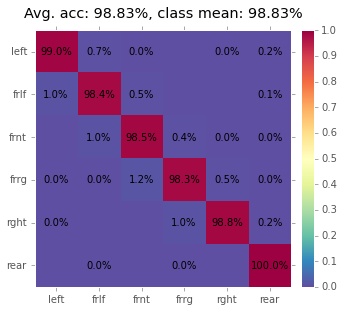

In [149]:
fig, ax = confusion(y_pred=np.concatenate(y_preds_hiit), y_true=np.concatenate([yte]*len(y_preds_hiit)), labels=le,
                    label_order=['left', 'frlf', 'frnt', 'frrg', 'rght', 'rear'])

---

# HOCoffee

In [153]:
Xtr, Xte, ytr, yte, ntr, nte, le = pickle.load(gzip.open('data/HOCoffee-wflip.pkl.gz', 'rb'))

In [16]:
aug = AugmentationPipeline(Xtr, ytr, Cropper((46,46)))

In [155]:
nets_hocoffee = [mknet_classification(len(le.classes_)) for _ in  range(5)]
print('{:.3f}M params'.format(count_params(nets_hocoffee[0])/1000000))

0.925M params


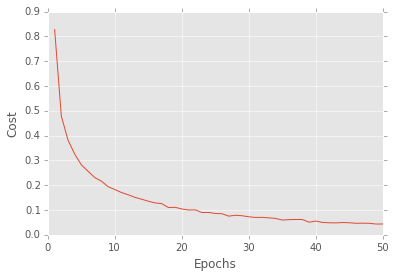

In [156]:
trains_hocoffee = [dotrain(net, df.ClassNLLCriterion(), aug, Xtr, ytr.astype(df.floatX)) for net in nets_hocoffee]

In [157]:
for model in nets_hocoffee:
    dostats(model, aug, Xtr, batchsize=1000)

In [159]:
y_preds_hocoffee = [dopred_clf(net, aug, Xte) for net in nets_hocoffee]

In [160]:
print("Average accuracy: {:.2%}".format(np.mean([np.mean(y_p == yte) for y_p in y_preds_hocoffee])))

Average accuracy: 87.40%


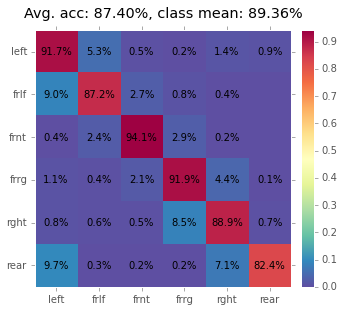

In [161]:
fig, ax = confusion(y_pred=np.concatenate(y_preds_hocoffee), y_true=np.concatenate([yte]*len(y_preds_hocoffee)), labels=le,
                    label_order=['left', 'frlf', 'frnt', 'frrg', 'rght', 'rear'])

---

# HOC 

In [162]:
Xtr, Xte, ytr, yte, ntr, nte, le = pickle.load(gzip.open('data/HOC-wflip.pkl.gz', 'rb'))

In [183]:
aug = AugmentationPipeline(Xtr, ytr, Cropper((123, 54)))

In [190]:
def mknet_hoc(nclass=len(le.classes_)):
    return df.Sequential(                          #     3@123x54
        df.SpatialConvolutionCUDNN( 3, 24, 3, 3),  # -> 24@121x52
        df.BatchNormalization(24),
        df.ReLU(),
        df.SpatialConvolutionCUDNN(24, 24, 3, 3),  # -> 24@119x50
        df.BatchNormalization(24),
        df.ReLU(),
        df.SpatialConvolutionCUDNN(24, 24, 3, 3),  # -> 24@117x48
        df.BatchNormalization(24),
        df.SpatialMaxPoolingCUDNN(3, 2),           # -> 24@39x24
        df.ReLU(),
        df.SpatialConvolutionCUDNN(24, 48, 3, 3),  # -> 48@37x22
        df.BatchNormalization(48),
        df.ReLU(),
        df.SpatialConvolutionCUDNN(48, 48, 3, 3),  # -> 48@35x20
        df.BatchNormalization(48),
        df.ReLU(),
        df.SpatialConvolutionCUDNN(48, 48, 3, 3),  # -> 48@33x18
        df.BatchNormalization(48),
        df.SpatialMaxPooling(3, 3),                # -> 48@11x6
        df.ReLU(),
        df.SpatialConvolutionCUDNN(48, 64, 3, 3),  # -> 64@9x4
        df.BatchNormalization(64),
        df.ReLU(),
        df.SpatialConvolutionCUDNN(64, 64, 3, 3),  # -> 64@7x2
        df.BatchNormalization(64),
        df.ReLU(),
        df.Dropout(0.2),
        Flatten(),
        df.Linear(64*7*2, 512),
        df.ReLU(),
        df.Dropout(0.5),
        df.Linear(512, nclass, initW=df.init.const(0)),
        df.SoftMax()
    )

In [191]:
nets_hoc = [mknet_hoc(len(le.classes_)) for _ in  range(5)]
print('{:.3f}M params'.format(count_params(nets_hoc[0])/1000000))

0.590M params


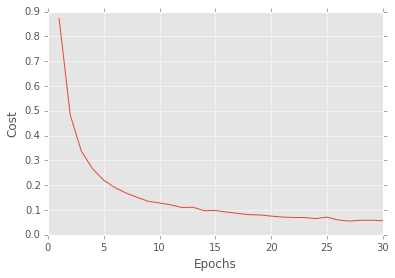

In [ ]:
trains_hoc = [dotrain(net, df.ClassNLLCriterion(), aug, Xtr, ytr.astype(df.floatX)) for net in nets_hoc]

In [194]:
for model in nets_hoc:
    dostats(model, aug, Xtr, batchsize=100)

In [195]:
y_preds_hoc = [dopred_clf(net, aug, Xte) for net in nets_hoc]

In [196]:
print("Average accuracy: {:.2%}".format(np.mean([np.mean(y_p == yte) for y_p in y_preds_hoc])))

Average accuracy: 83.87%


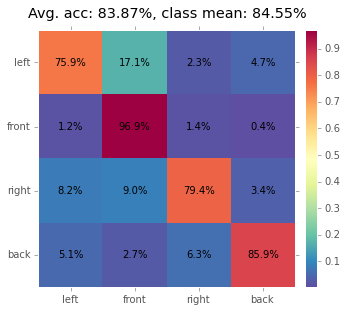

In [197]:
fig, ax = confusion(y_pred=np.concatenate(y_preds_hoc), y_true=np.concatenate([yte]*len(y_preds_hoc)), labels=le,
                    label_order=['left', 'front', 'right', 'back'])

---

# QMUL - No Background

In [223]:
Xtr, Xte, ytr, yte, ntr, nte, le = pickle.load(gzip.open('data/QMULPoseHeads-wflip.pkl.gz', 'rb'))

The following few steps remove the "background" class from the dataset.

First, remove all datapoints of that class.

In [228]:
not_bg = np.where(ytr != le.transform('background'))[0]
Xtr = Xtr[not_bg]
ytr = ytr[not_bg]
ntr = [ntr[i] for i in not_bg]
not_bg = np.where(yte != le.transform('background'))[0]
Xte = Xte[not_bg]
yte = yte[not_bg]
nte = [nte[i] for i in not_bg]

Then, shift the labels such that they are continuous again. No hole. Both in the targets as well as in the label encoder.

In [229]:
old_ytr = ytr.copy()
old_yte = yte.copy()
for new_lbl, old_lbl in enumerate([i for i, cls in enumerate(le.classes_) if cls != 'background']):
    ytr[old_ytr == old_lbl] = new_lbl
    yte[old_yte == old_lbl] = new_lbl
le.classes_ = np.array([c for c in le.classes_ if c != 'background'])

Done, now go on training as usual.

In [232]:
aug = AugmentationPipeline(Xtr, ytr, Cropper((46,46)))

In [233]:
nets_qmul4 = [mknet_classification(len(le.classes_)) for _ in  range(5)]
print('{:.3f}M params'.format(count_params(nets_qmul4[0])/1000000))

0.924M params


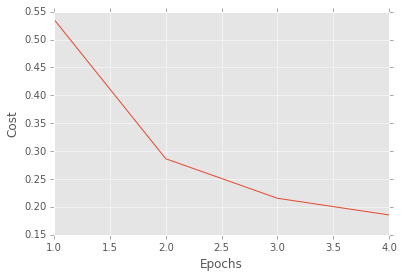

In [ ]:
trains_qmul4 = [dotrain(net, df.ClassNLLCriterion(), aug, Xtr, ytr.astype(df.floatX)) for net in nets_qmul4]

In [240]:
for model in nets_qmul4:
    dostats(model, aug, Xtr, batchsize=100)

In [241]:
y_preds_qmul4 = [dopred_clf(net, aug, Xte) for net in nets_qmul4]

In [242]:
print("Average accuracy: {:.2%}".format(np.mean([np.mean(y_p == yte) for y_p in y_preds_qmul4])))

Average accuracy: 95.84%


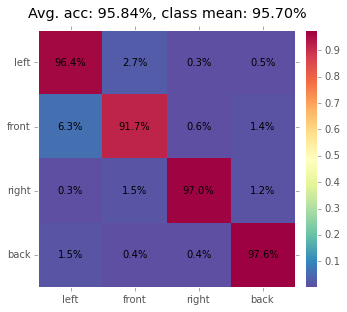

In [243]:
fig, ax = confusion(y_pred=np.concatenate(y_preds_qmul4), y_true=np.concatenate([yte]*len(y_preds_qmul4)), labels=le,
                    label_order=['left', 'front', 'right', 'back'])

---

# QMUL - With Background

In [212]:
Xtr, Xte, ytr, yte, ntr, nte, le = pickle.load(gzip.open('data/QMULPoseHeads-wflip.pkl.gz', 'rb'))

In [213]:
aug = AugmentationPipeline(Xtr, ytr, Cropper((46,46)))

In [214]:
nets_qmul = [mknet_classification(len(le.classes_)) for _ in  range(5)]
print('{:.3f}M params'.format(count_params(nets_qmul[0])/1000000))

0.925M params


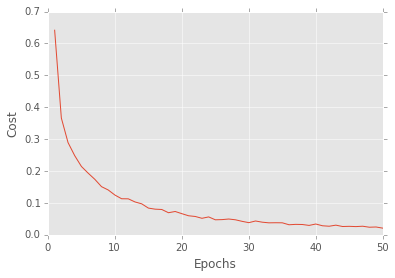

In [215]:
trains_qmul = [dotrain(net, df.ClassNLLCriterion(), aug, Xtr, ytr.astype(df.floatX)) for net in nets_qmul]

In [216]:
for model in nets_qmul:
    dostats(model, aug, Xtr, batchsize=100)

In [217]:
y_preds_qmul = [dopred_clf(net, aug, Xte) for net in nets_qmul]

In [218]:
print("Average accuracy: {:.2%}".format(np.mean([np.mean(y_p == yte) for y_p in y_preds_qmul])))

Average accuracy: 94.34%


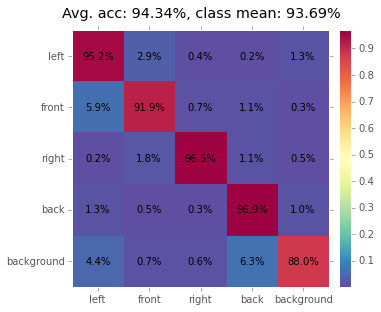

In [219]:
fig, ax = confusion(y_pred=np.concatenate(y_preds_qmul), y_true=np.concatenate([yte]*len(y_preds_qmul)), labels=le,
                    label_order=['left', 'front', 'right', 'back', 'background'])

# IDIAP Regression - Trilinear

In [528]:
(Xtr, Ptr, Ttr, Rtr, names_tr), (Xte, Pte, Tte, Rte, names_te) = pickle.load(open('data/IDIAP.pkl', 'rb'))
ytr, yte = np.array([Ptr, Ttr, Rtr]).T, np.array([Pte, Tte, Rte]).T

In [529]:
aug = AugmentationPipeline(Xtr, None, Cropper((68, 68)))

In [425]:
def mknet_idiap(*head):
    return mknet(*head, extra=df.SpatialMaxPoolingCUDNN(2,2))

In [426]:
nets_idiap = [mknet_idiap(df.Linear(512, 3, initW=df.init.const(0))) for _ in  range(5)]
print('{:.3f}M params'.format(count_params(nets_idiap[0])/1000000))

0.924M params


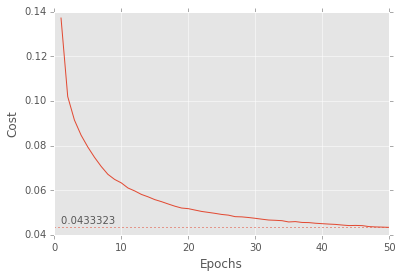

In [427]:
trains_idiap = [dotrain(net, df.MADCriterion(), aug, Xtr, np.array([Ptr, Ttr, Rtr]).T) for net in nets_idiap]

In [428]:
for model in nets_idiap:
    dostats(model, aug, Xtr, batchsize=100)

In [433]:
def ensemble_radians(angles):
    return np.arctan2(np.mean(np.sin(angles), axis=0), np.mean(np.cos(angles), axis=0))

In [434]:
def dopred_trilin(model, aug, X, batchsize=100):
    return dopred(model, aug, X, ensembling=ensemble_radians, output2preds=lambda x: x, batchsize=batchsize)

In [530]:
y_preds = [dopred_trilin(model, aug, Xte) for model in nets_idiap]

In [436]:
def maad_from_rad_as_deg(preds, reals):
    return np.rad2deg(np.abs(np.arctan2(np.sin(reals-preds), np.cos(reals-preds))))

In [531]:
errs = maad_from_rad_as_deg(y_preds, yte)
errs.shape

(5, 23991, 3)

In [532]:
mean_errs = np.mean(errs, axis=1)
std_errs = np.std(errs, axis=1)

Show the average across the five runs of the error and the error standard deviation.

In [533]:
avg_mean_err = np.mean(mean_errs, axis=0)
avg_std_err = np.mean(std_errs, axis=0)
print("Pan  Error: {:5.2f}°±{:5.2f}°".format(avg_mean_err[0], avg_std_err[0]))
print("Tilt Error: {:5.2f}°±{:5.2f}°".format(avg_mean_err[1], avg_std_err[1]))
print("Roll Error: {:5.2f}°±{:5.2f}°".format(avg_mean_err[2], avg_std_err[2]))

Pan  Error:  5.11°± 7.00°
Tilt Error:  2.73°± 2.84°
Roll Error:  3.65°± 4.10°


And now the standard deviation across the five runs of the above.

In [534]:
std_mean_err = np.std(mean_errs, axis=0)
std_std_err = np.std(std_errs, axis=0)
print("Pan  Error stdev.: {:5.2f}°±{:5.2f}°".format(std_mean_err[0], std_std_err[0]))
print("Tilt Error stdev.: {:5.2f}°±{:5.2f}°".format(std_mean_err[1], std_std_err[1]))
print("Roll Error stdev.: {:5.2f}°±{:5.2f}°".format(std_mean_err[2], std_std_err[2]))

Pan  Error stdev.:  0.45°± 0.77°
Tilt Error stdev.:  0.33°± 0.14°
Roll Error stdev.:  0.10°± 0.74°


# CAVIAR

In [442]:
def mknet_caviar():
    return mknet(df.Linear(512, 1, initW=df.init.const(0)))

In [555]:
def ensemble_degrees(angles):
    return np.arctan2(np.mean(np.sin(np.deg2rad(angles)), axis=0), np.mean(np.cos(np.deg2rad(angles)), axis=0))

In [556]:
def dopred_deg(model, aug, X, batchsize=100):
    return dopred(model, aug, X, ensembling=ensemble_degrees, output2preds=lambda x: x, batchsize=batchsize)

In [558]:
def maad_from_deg(preds, reals):
    return np.rad2deg(np.abs(np.arctan2(np.sin(np.deg2rad(reals-preds)), np.cos(np.deg2rad(reals-preds)))))

## "Clean"

In [535]:
(Xtr, Ptr, *_), (Xte, Pte, *_) = pickle.load(gzip.open('data/CAVIAR-c.pkl.gz', 'rb'))

In [536]:
aug = AugmentationPipeline(Xtr, None, Cropper((46,46)))

In [512]:
nets_caviar_c = [mknet_caviar() for _ in  range(5)]
print('{:.3f}M params'.format(count_params(nets_caviar_c[0])/1000000))

0.922M params


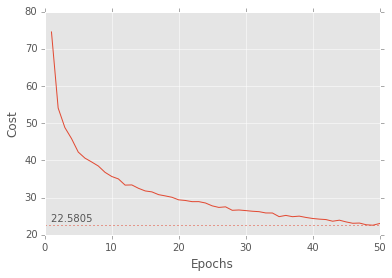

In [513]:
trains_caviar_c = [dotrain(net, df.MADCriterion(), aug, Xtr, Ptr[:,None]) for net in nets_caviar_c]

In [514]:
for model in nets_caviar_c:
    dostats(model, aug, Xtr, batchsize=100)

In [557]:
y_preds = [dopred_deg(model, aug, Xte) for model in nets_caviar_c]

In [559]:
errs = maad_from_rad_as_deg(y_preds, np.deg2rad(Pte[:,None]))
errs.shape

(5, 10665, 1)

In [560]:
mean_errs = np.mean(errs, axis=1)
std_errs = np.std(errs, axis=1)

Same story as above.

In [561]:
print("Pan Error:        {:5.2f}°±{:5.2f}°".format(np.mean(mean_errs), np.mean(std_errs)))
print("Pan Error stdev.: {:5.2f}°±{:5.2f}°".format(np.std(mean_errs), np.std(std_errs)))

Pan Error:        20.94°±23.93°
Pan Error stdev.:  1.66°± 1.23°


## With occlusions

In [562]:
(Xtr, Ptr, *_), (Xte, Pte, *_) = pickle.load(gzip.open('data/CAVIAR-o.pkl.gz', 'rb'))

In [563]:
aug = AugmentationPipeline(Xtr, None, Cropper((46,46)))

In [564]:
nets_caviar_o = [mknet_caviar() for _ in  range(5)]
print('{:.3f}M params'.format(count_params(nets_caviar_o[0])/1000000))

0.922M params


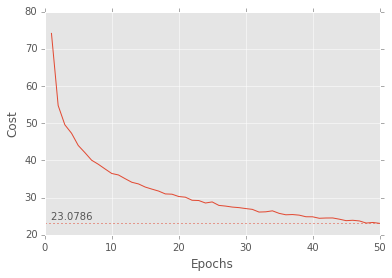

In [565]:
trains_caviar_o = [dotrain(net, df.MADCriterion(), aug, Xtr, Ptr[:,None]) for net in nets_caviar_o]

In [566]:
for model in nets_caviar_o:
    dostats(model, aug, Xtr, batchsize=100)

In [567]:
y_preds = [dopred_deg(model, aug, Xte) for model in nets_caviar_o]

In [568]:
errs = maad_from_rad_as_deg(y_preds, np.deg2rad(Pte[:,None]))
errs.shape

(5, 10889, 1)

In [570]:
mean_errs = np.mean(errs, axis=1)
std_errs = np.std(errs, axis=1)

In [571]:
print("Pan Error:        {:5.2f}°±{:5.2f}°".format(np.mean(mean_errs), np.mean(std_errs)))
print("Pan Error stdev.: {:5.2f}°±{:5.2f}°".format(np.std(mean_errs), np.std(std_errs)))

Pan Error:        26.66°±25.54°
Pan Error stdev.:  2.30°± 1.59°
